In [1]:
%load_ext autoreload
%autoreload 2
"""
    Some imports used throughout the
    notebook
"""
import time

from visualize import *

import cpmpy
from cpmpy.transformations.normalize import toplevel_list
from factory import *
from read_data import get_data
from cpmpy.tools.explain import mus
from cpmpy.tools.explain.utils import make_assump_model

import numpy as np
np.set_printoptions(linewidth=90)
# preload solvers
from cpmpy import SolverLookup
names = SolverLookup.solvernames()

import networkx as nx
import re
draw = lambda g,**kwargs : nx.draw_circular(g, width=5, node_size=500,**kwargs)
cmap = ["black", "yellow", "cyan", "lightgreen", "blue"]

def pinpoint_to_constraints(G, model):
    #assert model.solve()
    draw_conflict(G, mus(m.constraints))

def graph_coloring(G, max_colors=None):
    n = G.number_of_nodes()
    if max_colors is None:
        max_colors = n
    
    m = cp.Model()
    # worst case: give each node a different color
    nodes = cp.intvar(1, max_colors, shape=n, name="Node")
    # constrain edges to have differently colored nodes
    m += [nodes[n1] != nodes[n2] for n1, n2 in G.edges()]
    m.minimize(cp.max(nodes))
    
    return m, nodes

def graph_highlight(graph, cons, **kwargs):
    edges = []
    for c in cons:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        edges.append((a,b))
        
    colors = ["red" if (a,b) in edges else "black" for (a,b) in graph.edges()]       
    return draw(graph, edge_color=colors, **kwargs)

def get_avg_outputlits(seq):
    lits = sum(len(out.literals()) for _,_,out in seq[:-1])
    return lits / (len(seq)-1)

def get_avg_stepsize(seq):
    return sum(len(s) for _,s,_ in seq) / len(seq)

## Explanation techniques for CP
### Prof. Tias Guns, KU Leuven, Belgium
#### In collaboration with Ignace Bleukx, Emilio Gamba, Bart Bogaerts, Jo Devriendt, Dimos Tsouros

<table><tr style="background: white;">
    <td>&nbsp;</td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/kul.jpg" width=40%></td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/erc.jpg" width=45%></td>
</tr></table>

<!-- Thanks to Bart Bogaerts, Emilio Gamba and Jo Devriendt -->


<small>This presentation is an executable Jupyter notebook</small>

Link to slides and more examples: https://github.com/CPMpy/XCP-explain

## AI and Constraint Solving

<center><img src="img/intro_ai.png" width="65%" align="center" style="margin-top:10px"></center>


## Constraint Solving

<img src="img/solutions_vizual.png" width="45%" align="right" style="margin-top:100px">

Solving combinatorial optimization problems in AI

- Vehicle Routing

- Scheduling

- Manufacturing

- Other combinatorial problems ...

## Model + Solve

<center><img src="img/model_solve.png" width=70%></center>

- Reason over the constraints to find a solution
- Find the optimal solution according to the objective 
    - (maximize gain or minimize penalty)

- What if no solution is found?
- What if the user does not _like_ the solution?
- What if the user _expected_ a different solution?
- ...


## What happens after Model + Solve?

<center><img src="img/model_solve.png" width=70%></center>

- What if no solution is found?
- What if the user does not _like_ the solution?
- What if the user _expected_ a different solution?
- ...


<center><img src="img/chatopt1.png"></center>

<center><img src="img/chatopt2.png"></center>

<center><img src="img/chatopt3.png"></center>

<center><img src="img/chatopt4.png"></center>

## Explainable Constraint Programming (XCP)

In general, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

<center><img src="img/interaction_figure4.png" width=20%></center>


<!-- Can be combined in interactive systems:
  - _Iteratively refine explanation & model_ -->

## Explainable Constraint Programming (XCP)

In general, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

<img src="img/interaction_figure4.png" width=20% align="right">

- **Deductive explanation:**
  - _What causes X?_
- **Counterfactual explanation**:
  - _What if I want Y instead of X?_


<!-- Can be combined in interactive systems:
  - _Iteratively refine explanation & model_ -->

Note <i>explanations</i> also used in the context of lazy-clause generation: one propagator explains its inference to a SAT solver. We focus on <b>user-oriented explanations</b> involving multiple constraints.

# Example XCP interaction

Toy example, graph coloring:

color each node such that no two adjacent nodes have the same color<br>
(real example: assign each booking request (node) to a room (color) such that no temporally overlapping requests use the same room)

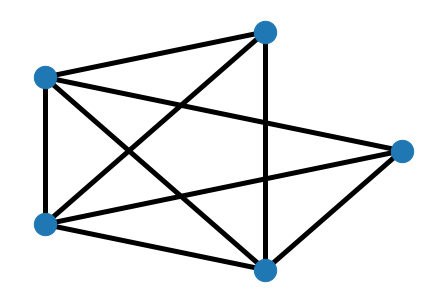

In [2]:
G = nx.fast_gnp_random_graph(5, 0.8, seed=0)
draw(G)

# Example XCP interaction

## Lets color this graph...

ExitStatus.OPTIMAL (0.00700667 seconds)
Found optimal coloring with 4 colors


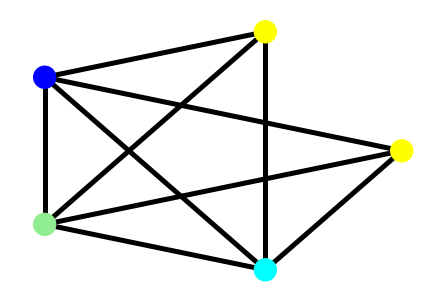

In [3]:
m, nodes = graph_coloring(G, max_colors=None)
if m.solve():
    print(m.status())
    print(f"Found optimal coloring with {m.objective_value()} colors")
    draw(G, node_color=[cmap[n.value()] for n in nodes])
else:
    print("No solution found.")

# Example XCP interaction

Found optimal coloring with 4 colors


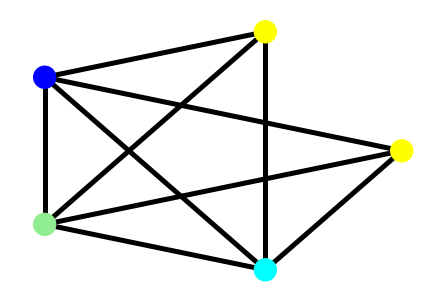

In [4]:
print(f"Found optimal coloring with {m.objective_value()} colors")
draw(G, node_color=[cmap[n.value()] for n in nodes])

<img src="img/why.png" width="15%" align="left" style="margin-top:-40px; margin-right:50px; margin-left: 300px">
yes... but why do we need 4? 

# Example XCP interaction

## _Why_ do we need 4 colors?

Deductive explanation: pinpoint to constraints _causing_ this fact

UNSAT is caused by the following constraints:


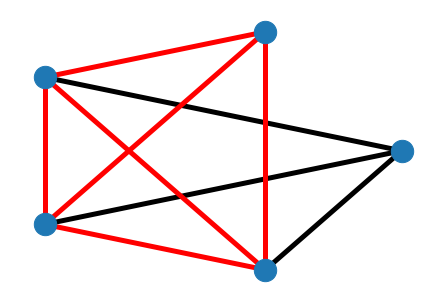

In [5]:
m, nodes = graph_coloring(G, max_colors=3) # less than 4?
if m.solve() is False:
    conflict = cpmpy.tools.explain.mus(m.constraints)  # Minimal Unsatisfiable Subset
    print("UNSAT is caused by the following constraints:")
    graph_highlight(G, conflict)

# Example XCP interaction

## _Why_ do we need 4 colors?

Counterfactual explanation: pinpoint to constraint *changes* that would allow, e.g. 3 colors

UNSAT can be resolved by removing the following constraints:


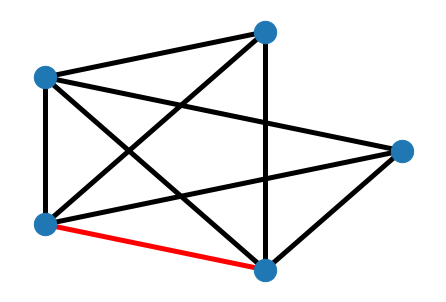

In [6]:
m, nodes = graph_coloring(G, max_colors=3) # less than 4?
if m.solve() is False:    
    corr = cpmpy.tools.explain.mcs(m.constraints)  # Minimal Correction Subset
    print("UNSAT can be resolved by removing the following constraints:")
    graph_highlight(G, corr)

# Example XCP interaction

## _Why_ do we need 4 colors?

Counterfactual explanation: pinpoint to constraint *changes* that would allow, e.g. 3 colors

Can now compute the counterfactual solution:

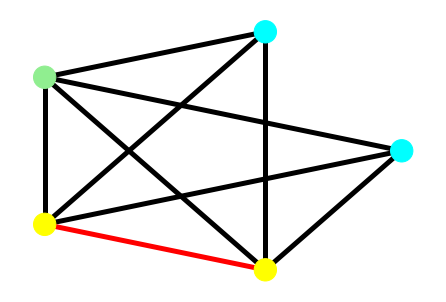

In [7]:
# compute and visualise counter-factual solution
m2 = cp.Model([c for c in m.constraints if c not in corr])
m2.solve()
graph_highlight(G, corr, node_color=[cmap[n.value()] for n in nodes])

# Explanation techniques in the wild

<center><img src="img/app_explanations.png"  style="max-width: 80%;"></center>

## CPMpy: http://cpmpy.readthedocs.io

We will use the CPMpy modeling library in Python for this presentation

<center><img src="img/cpmpy-intro.png" style="max-width: 70%;" /></center>


## Running example in this talk: Nurse Scheduling

* The assignment of _shifts_ and _holidays_ to nurses.
* Each nurse has their own restrictions and preferences,
    as does the hospital.

### hospital constraints:

<img src="img/nurse_rost_prob.jpg" align="right">

* nb of shifts required on each day
* max nb of shifts per nurse
* max nb of weekend shifts
* min/max consecutive shifts

### nurse constraints / preferences:

* specific days off-duty
* specific shift requests (on/off)

## Running example in this talk: Nurse Scheduling

* The assignment of _shifts_ and _holidays_ to nurses.
* Each nurse has their own restrictions and preferences,
    as does the hospital.

In [8]:
instance = "Benchmarks/Instance1.txt"  # "http://www.schedulingbenchmarks.org/nrp/data/Instance1.txt"
data = get_data(instance)

## Nurse Rostering: data

Instances from http://www.schedulingbenchmarks.org/

"benchmark test instances from various sources including industrial collaborators and scientific publications."

<!-- 7 types of hospital constraints, 2 types of nurse constraints -->

In [9]:
 #instance = "http://www.schedulingbenchmarks.org/nrp/data/Instance1.txt"
instance = "Benchmarks/Instance1.txt"
data = get_data(instance)

factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_full_model()  # CPMpy model with all constraints

model.solve() 
visualize(nurse_view.value(), factory)  # live decorated dataframe

In [10]:
print("Nr of days to schedule:", data.horizon)
print("Nr of shift types:", len(data.shifts))

pd.merge(data.days_off, data.staff[["# ID","name"]], left_on="EmployeeID", right_on="# ID", how="left")

Nr of days to schedule: 14
Nr of shift types: 1


,DayIdx,# ID,name
0,0,A,Megan
1,5,B,Katherine
2,8,C,Robert
3,2,D,Jonathan
4,9,E,William
5,5,F,Richard
6,1,G,Kristen
7,7,H,Kevin


# Outline of the talk

## Part 1: Deductive explanations (What causes X?)

* UNSAT: minimal unsatisfiable subsets &#9194;
  - efficient MUSes
  - preferred MUSes
* SAT: explaining logical consequences
* OPT: explaining that no better solution exists

## Part 2: Counterfactual explanation (What if Y instead of X?)

* UNSAT: minimum correction subsets
* UNSAT: corrective actions
* SAT: checking a foil
* OPT: correcting the objective function
    

## Deductive Explanations for UNSAT problems

In [11]:
# decision model, add all nurse preferences as hard constraints
factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_decision_model()
model.solve()

False

... no solution found

In [12]:
constraints = toplevel_list(model.constraints, merge_and=False) # normalization for later
print(f"Model has {len(constraints)} constraints:")
for cons in constraints: print("-", cons)

Model has 168 constraints:
- Megan cannot work more than 14 shifts of type 1
- Katherine cannot work more than 14 shifts of type 1
- Robert cannot work more than 14 shifts of type 1
- Jonathan cannot work more than 14 shifts of type 1
- William cannot work more than 14 shifts of type 1
- Richard cannot work more than 14 shifts of type 1
- Kristen cannot work more than 14 shifts of type 1
- Kevin cannot work more than 14 shifts of type 1
- Megan cannot work more than 4320min
- Katherine cannot work more than 4320min
- Robert cannot work more than 4320min
- Jonathan cannot work more than 4320min
- William cannot work more than 4320min
- Richard cannot work more than 4320min
- Kristen cannot work more than 4320min
- Kevin cannot work more than 4320min
- Megan cannot work more than 3360min
- Katherine cannot work more than 3360min
- Robert cannot work more than 3360min
- Jonathan cannot work more than 3360min
- William cannot work more than 3360min
- Richard cannot work more than 3360min
-

## Converting to Decision model


<img src="img/explain_unsat.png" width="15%" align="left" style="margin:50px;">

* Model nurse rostering problem as decision problem <br>
    (no objective)
        
* Nurse **preferences** are also hard constraints

## Deductive Explanations for UNSAT problems

The set of all constraints is unsatisfiable.

<img src="img/allcons.png" width="20%" float="right" style="margin:50px;">


But do all constraints contribute to this?

## Deductive Explanations for UNSAT problems

### Minimal Unsatisfiable Subset (MUS)

<img src="img/mus.png" width="20%" align="left" style="margin:50px;">

Pinpoint to constraints causing a conflict

... trim model to a minimal set of constraints

... minimize cognitive burden for user


### How to compute a MUS?

Deletion-based MUS algorithm

_[Joao Marques-Silva. Minimal Unsatisfiability: Models, Algorithms and Applications. ISMVL 2010. pp. 9-14]_

In [13]:
def mus_naive(constraints):
    m = cp.Model(constraints)
    assert m.solve() is False, "Model should be UNSAT"
    
    core = constraints
    i = 0
    while i < len(core):
        subcore = core[:i] + core[i+1:]  # try all but constraint 'i'
        if cp.Model(subcore).solve() is True:
            i += 1  # removing 'i' makes it SAT, need to keep for UNSAT
        else:
            core = subcore #  can safely delete 'i'
    return core

### How to compute a MUS, <u>efficiently</u>?

In [14]:
t0 = time.time()
core = mus_naive(constraints)
print(f"Naive MUS took {time.time()-t0} seconds")

Naive MUS took 50.710354804992676 seconds


In [15]:
t0 = time.time()
core = cpmpy.tools.explain.mus(constraints, solver="exact")
print(f"Assumption-based MUS took {time.time()-t0} seconds")

Assumption-based MUS took 3.3157269954681396 seconds


### How to compute a MUS, <u>efficiently</u>?



In [16]:
def mus_assum(constraints, solver="ortools"):
    # add indicator variable per expression
    constraints = toplevel_list(constraints, merge_and=False)
    assump = cp.boolvar(shape=len(constraints), name="assump")  # Boolean indicators
    m = cp.Model(assump.implies(constraints))  # [assump[i] -> constraints[i] for all i]
    
    s = cp.SolverLookup.get(solver, model)
    assert s.solve(assumptions=assump) is False, "Model should be UNSAT"

    core = s.get_core()  # start from solver's UNSAT core of assumption variables
    i = 0
    while i < len(core):
        subcore = core[:i] + core[i+1:]  # try all but constraint 'i'
        if s.solve(assumptions=subcore) is True:
            i += 1  # removing 'i' makes it SAT, need to keep for UNSAT
        else:
            core = subcore
    return [c for c,var in zip(constraints,assump) if var in core]

### How to compute a MUS, <u>efficiently</u>?

<center><img src="img/mus_assum.png" style="max-width: 85%;" /></center>

## Deepdive: incremental CDCL solving with assumption variables 1/4

<center><img src="img/slide_cdcl1.png" style="max-width: 85%;" /></center>

## Deepdive: incremental CDCL solving with assumption variables 2/4

<center><img src="img/slide_cdcl2.png" style="max-width: 85%;" /></center>

## Deepdive: incremental CDCL solving with assumption variables 3/4

<center><img src="img/slide_cdcl3.png" style="max-width: 85%;" /></center>

## Deepdive: incremental CDCL solving with assumption variables 4/4

<center><img src="img/slide_cdcl4.png" style="max-width: 85%;" /></center>

### How to compute a MUS, <u>efficiently</u>? (recap after deepdive)

<center><img src="img/mus_assum.png" style="max-width: 85%;" /></center>

### How to compute a MUS, <u>efficiently</u>?

Assumption-based incremental solving only for Boolean SAT problems?

<b>No!</b>

* CP solvers: <i>Lazy Clause Generation</i> (e.g. OrTools)
* Pseudo-Boolean solvers: <i>Conflict-Driven Cutting Plane Learning</i> (e.g. Exact)
* SMT solvers: <i>SAT Module Theories with CDCL</i> (e.g. Z3)
* MaxSAT solvers: <i>Core-guided solvers</i>

## Deductive Explanations for UNSAT problems

A MUS is a deductive explanation of UNSAT:

these constraints minimally entail failure


In [17]:
subset = cpmpy.tools.explain.mus(constraints)
print("Length of MUS:", len(subset))
for cons in subset: print("-", cons)

Length of MUS: 11
- Shift D on Sat 1 must be covered by 5 nurses out of 8
- Robert can work at most 5 days before having a day off
- Kevin should work at most 1 weekends
- Katherine has a day off on Sat 1
- Richard has a day off on Sat 1
- Robert requests to work shift D on Mon 1
- Robert requests to work shift D on Tue 1
- Robert requests to work shift D on Wed 1
- Robert requests to work shift D on Thu 1
- Robert requests to work shift D on Fri 1
- Kevin requests to work shift D on Sun 2


In [18]:
visualize_constraints(subset, nurse_view, factory)

### Many MUS'es may exist...

_Liffiton, M.H., & Malik, A. (2013). Enumerating infeasibility: Finding multiple MUSes quickly. In
Proceedings of the 10th International Conference on Integration of AI and OR Techniques in Constraint
    Programming (CPAIOR 2013) (pp. 160–175)_

In [19]:
# MARCO MUS/MSS enumeration
from explanations.marco_mcs_mus import do_marco
solver = "ortools"  # default solver
if "exact" in cp.SolverLookup.solvernames(): solver = "exact"  # fast for increment solving
    
t0 = time.time()
cnt = 0
for (kind, sset) in do_marco(model, solver=solver):
    if kind == "MUS":
        print("M", end="")
        cnt += 1
    else: print(".", end="")  # MSS
    
    if time.time() - t0 > 15:  break  # for this presentation: break after 15s
print(f"\nFound {cnt} MUSes in", time.time() - t0)
 

MMMMMMMMMMMMM.MMMMMMM.MMMM.MMMMMMMMMM.MMMMMMMMMMM..MMMMMMMM.MMMMMMMMMMMMMMMMM.MMMMMMMMMM.MMMM..MMMMMMMMMMMM..M.M.M..MMM..MM.M.....MMMMMMMM.MMMM..MMMMMMMM..MMMMMMM..MMMMM....MMMMMMM.MMMMMMMMM..MMMMMMMMM.MM.M.
Found 165 MUSes in 15.01483416557312


### Many MUS'es may exist...

<img src="img/musses.png" width="40%" align="left" style="margin-left:30px; margin-right:30px">

This problem has just 168 constraints, yet 100.000+ MUSes exist...

Which one to show? 

Can we influence which MUS is found?

## Influencing which MUS is found?

<b>QuickXPlain algorithm</b> <i>(Junker, 2004)</i>.
Widely used, in model-based diagnosis, recommender systems, verification, and more.

Divide-and-conquer given a lexicographic <i>preference</i> order over the constraints:

In [20]:
# the order of 'soft' matters! lexicographic preference for the first ones
def quickxplain(soft, hard=[], solver="ortools"):
    model, soft, assump = make_assump_model(soft, hard)
    s = cp.SolverLookup.get(solver, model)
    assert s.solve(assumptions=assump) is False, "The model should be UNSAT!"

    # the recursive call
    def do_recursion(tocheck, other, delta):
        if len(delta) != 0 and s.solve(assumptions=tocheck) is False:
            # conflict is in hard constraints, no need to recurse
            return []

        if len(other) == 1:
            # conflict is not in 'tocheck' constraints, but only 1 'other' constraint
            return list(other)  # base case of recursion

        split = len(other) // 2  # determine split point
        more_preferred, less_preferred = other[:split], other[split:]  # split constraints into two sets

        # treat more preferred part as hard and find extra constants from less preferred
        delta2 = do_recursion(tocheck + more_preferred, less_preferred, more_preferred)
        # find which preferred constraints exactly
        delta1 = do_recursion(tocheck + delta2, more_preferred, delta2)
        return delta1 + delta2

    core = do_recursion([], list(assump), [])
    return [c for c,var in zip(soft,assump) if var in core]


  ## Influencing which MUS is found?

<b>QuickXPlain</b>: Divide-and-conquer given a lexicographic <i>preference</i> order over the constraints:

&nbsp;

<center><img src="img/quickxplain.png" style="max-width: 70%;" /></center>

## Influencing which MUS is found?

<b>QuickXPlain algorithm</b> <i>(Junker, 2004)</i>.
Widely used, in model-based diagnosis, recommender systems, verification, and more.

Divide-and-conquer given a lexicographic order over the constraints

In [21]:
t0 = time.time()
subset = cpmpy.tools.explain.quickxplain(sorted(model.constraints, key=lambda c: -len(c)), solver="exact")
print("ordering '-len': Length of MUS:", len(subset))
print(f"(in {time.time()-t0} seconds)")

t0 = time.time()
subset = cpmpy.tools.explain.quickxplain(sorted(model.constraints, key=lambda c: len(c)), solver="exact")
print("ordering 'len': Length of MUS:", len(subset))
print(f"(in {time.time()-t0} seconds)")

ordering '-len': Length of MUS: 18
(in 2.9135823249816895 seconds)
ordering 'len': Length of MUS: 3
(in 2.795252799987793 seconds)


In [22]:
t0 = time.time()
subset = cpmpy.tools.explain.quickxplain(sorted(model.constraints, key=lambda c: len(c)), solver="ortools")
print("ordering 'len': Length of MUS:", len(subset))
print(f"(in {time.time()-t0} seconds)")

ordering 'len': Length of MUS: 3
(in 3.0860371589660645 seconds)


In [23]:
visualize_constraints(subset, nurse_view, factory)

## Optimising which MUS is found?

Give every constraint a weight: OUS: Optimal Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>.

Some key properties:

1. If a subset is SAT, can <i>grow</i> it to a Maximal Satisfiable Subset (MSS)
2. The complement of a MSS is a Minimum Correction Subset (MCS)
3. Theorem: A MUS is a hitting set of the MCSes

<table><tr>
    <td width=10%>
        <center><img width=60% src="img/mcs.png" /></center>
    </td> 
    <td width=10%>
        <center><img width=60% src="img/hittingset.png" /></center>
    </td>
</tr></table>

## Optimising which MUS is found?

OUS: Optimal Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>. Every constraints has a weight.

1. Initialize sets-to-hit $\mathcal{H}$ (e.g. insert set of all constraints)
2. Find *optimal* hitting set $S$
3. Check if SAT: grow and take complement = MCS $K$, add to sets-to-hit $\mathcal{H}$
4. Repeat until UNSAT: optimal unsatisfiable subset $S$ found

<center><img src="img/smus.png" width=55% /></center>

## <u>Efficiently</u> optimising which MUS is found?

OUS: Optimal Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>. Every constraints has a weight.

&nbsp;

<center><img src="img/smus_efficient.png" width=65%/></center>

## Optimising which MUS is found?

OUS: Optimal Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>. Every constraints has a weight.

In [24]:
from explanations.subset import omus  # not (yet) part of CPMpy

smallest_subset = omus(model.constraints, weights=1, solver="exact", hs_solver="ortools")

print("Length of OUS:", len(smallest_subset))
for cons in smallest_subset:  
    print("-", cons)

Length of OUS: 3
- Robert has a day off on Tue 2
- Richard requests to not work shift D on Tue 2
- Shift D on Tue 2 must be covered by 7 nurses out of 8


In [25]:
visualize_constraints(smallest_subset, nurse_view, factory)

# Outline of the talk

## Part 1: Deductive explanations (What causes X?)

* UNSAT: minimal unsatisfiable subsets
  - efficient MUSes
  - preferred MUSes
* SAT: explaining logical consequences &#9194;
* OPT: explaining that no better solution exists

## Part 2: Counterfactual explanation (What if Y instead of X?)

* UNSAT: minimum correction subsets
* UNSAT: corrective actions
* SAT: checking a foil
* OPT: correcting the objective function
    

## Deductive Explanations for SAT problems


&nbsp;

<center><img src="img/maxconsequence.png" width=75%/></center>

## Deductive Explanations for SAT problems

### Explaining logical consequences

<u>Logical consequence</u>: a variable assignment entailed by the constraints and the current partial assignment

<u>Maximal consequence</u>: precision- maximal partial assignment

* Maximal consequence = intersection of all possible solutions
* If solution is unique, maximal consequence = unique solution

### TODO: Simple algorithm of max-propagate? (not priority)

## Deductive Explanations for SAT problems

> Bogaerts, Bart, Emilio Gamba, and Tias Guns. "A framework for step-wise explaining how to solve constraint satisfaction problems." Artificial Intelligence 300 (2021): 103550.

&nbsp;

<center><img src="img/stepwise.png" /></center>

## Deductive Explanations for SAT problems

> Bogaerts, Bart, Emilio Gamba, and Tias Guns. "A framework for step-wise explaining how to solve constraint satisfaction problems." Artificial Intelligence 300 (2021): 103550.

<table><tr style="background: white;">
    <td>&nbsp;</td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/onestep_example.png" width=90%></td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/onestep_expl.png" width=80%></td>
</tr></table>

## Deductive Explanations for SAT problems

We want each explanation step to be as simple as possible.

<center><img src="img/onestep_mus.png" width=50%></center>

(we actually use OUS because we want the <i>smallest</i> not just a minimal one, and then we can put smaller weights on facts and larger weights on constraints)

## <u>Efficiently</u> step-wise explanation of the maximal consequence?

Compute the OUS over all assignments in the maximal consequence at once, efficiently:

<b>OCUS</b> Optimal <i>Constrained</i> Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>.

* <i>meta-constraint $p$:</i> use exactly 1 element of the maximal consequence

<center><img src="img/ocus.png" width=50%></center>

(not discussed in more detail)

# Outline of the talk

## Part 1: Deductive explanations (What causes X?)

* UNSAT: minimal unsatisfiable subsets
  - efficient MUSes
  - preferred MUSes
* SAT: explaining logical consequences
* OPT: explaining that no better solution exists &#9194;

## Part 2: Counterfactual explanation (What if Y instead of X?)

* UNSAT: minimum correction subsets
* UNSAT: corrective actions
* SAT: checking a foil
* OPT: correcting the objective function
    

## Deductive Explanations for <u>OPT</u> problems

Can we explain <i>why</i> an optimal solution is optimal, e.g. <u>why there does not exist a better solution</u>?

A <i>proof of optimality</i> proves that no better solution exists, but:

* An increasing number of solvers support <i>proof logging</i> (SAT, but also CP: Glasgow Constraint Solver)
* These proofs are built for <i>computer</i> verification (up to gigabytes of log), not to communicate to users
* These proofs can use learned clauses, auxiliary variables and anything available to the solver

## Deductive Explanations for <u>OPT</u> problems

Can we explain <i>why</i> an optimal solution is optimal, e.g. <u>why there does not exist a better solution</u>?

Let $C$ be the constraints, $f(x)$ the objective function and $o$ the optimal objective value.

* $o = min_{x \in C} f(x)$ <b>because</b> of the constraints $C$
* Hence $C ~\wedge ~(f(x) < o)$ is unsatisfiable...
* Hence $\text{MUS}(C ~\wedge ~(f(x) < o))$ is a deductive explanation for optimality!

But its typically very big (up to all constraints)...

can we provide a <b>step-wise explanation</b> of the unsatisfiability?

## Deductive Explanations for <u>OPT</u> problems

Can we explain <i>why</i> an optimal solution is optimal, e.g. <u>a step-wise explanation of why</u> there does not exist a better solution?

Yes!

> Ignace Bleukx, Jo Devriendt, Emilio Gamba, Bart Bogaerts, Tias Guns. Simplifying Step-wise Explanation Sequences. 29th International Conference on Principles and Practice of Constraint Programming (CP23), 2023.


**Challenges**

- How to find interpretable sequences? 
    - _I.e., with few and small steps?_
- How to deal with redundancy in the sequence? 
    - _I.e., how to decide what information is relevant to derive?_
- How to make the algorithm incremental?
    - _I.e., how to find good sequences fast?_

## Deductive Explanations for <u>OPT</u> problems

Example in this tutorial: step-wise explanation of a large MUS<br />(can also construct from scratch to step-wise explain optimality, see paper)

In [26]:
# any MUS
subset = cpmpy.tools.explain.mus(model.constraints)
visualize_constraints(subset, nurse_view, factory)

In [27]:
from explanations.stepwise import find_sequence

seq = find_sequence(subset)

Found sequence of length 11
Filtered sequence to length 11


In [28]:
nurse_view.clear()
visualize_step(seq[0], nurse_view, factory)

Propagating constraint: Katherine has a day off on Sat 1


In [29]:
visualize_step(seq[1], nurse_view, factory)

Propagating constraint: Richard has a day off on Sat 1


In [30]:
visualize_step(seq[2], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Mon 1


In [31]:
visualize_step(seq[3], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Tue 1


In [32]:
visualize_step(seq[4], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Wed 1


In [33]:
visualize_step(seq[5], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Thu 1


In [34]:
visualize_step(seq[6], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Fri 1


In [35]:
visualize_step(seq[7], nurse_view, factory)

Propagating constraint: Robert can work at most 5 days before having a day off


In [36]:
visualize_step(seq[8], nurse_view, factory)

Propagating constraint: Shift D on Sat 1 must be covered by 5 nurses out of 8


In [37]:
visualize_step(seq[9], nurse_view, factory)

Propagating constraint: Kevin should work at most 1 weekends


In [38]:
visualize_step(seq[10], nurse_view, factory)

Propagating constraint: Kevin requests to work shift D on Sun 2


# Outline of the talk

## Part 1: Deductive explanations (What causes X?) &#9989;

* UNSAT: minimal unsatisfiable subsets
  - efficient MUSes
  - preferred MUSes
* SAT: explaining logical consequences
* OPT: explaining that no better solution exists

## Part 2: Counterfactual explanation (What if Y instead of X?)  &#9194;

* UNSAT: minimum correction subsets
* UNSAT: corrective actions
* SAT: checking a foil
* OPT: correcting the objective function
    

## Explainable Constraint Programming (XCP)

Recap, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

<img src="img/coloring_mus.png" width=25% align="right">

- **Deductive explanation:**
  - _What causes X?_
  - answer: a minimal inference set

<img src="img/coloring_mcs.png" width=25% align="right">

- **Counterfactual explanation**:
  - _What if I want Y instead of X?_
  - answer: a constraint relaxation + new solution

## Explanations for UNSAT problems:

<table><tr>
    <td width=45%>      
        <center>MUS: one conflict
            <img width=60% src="img/mus.png" /></center>
    </td> 
    <td width=45%>
        <center>MSS: a relaxation
        <img width=60% src="img/mcs.png" /></center>
    </td>
</tr></table>

## Counterfactual Explanations for <u>UNSAT</u> problems

Computing a <i>Maximal Satisfiable Subset</i>?

We can do better... computing a Maxi<b>mum</b> satisfiable subset is the textbook MaxSAT/MaxCSP problem!

Can add Boolean indicator variable to every constraint (like in assumption-based solving), and maximize the sum of indicators...

In [39]:
# add indicator variable per expression
constraints = toplevel_list(model.constraints, merge_and=False)

ind = cp.boolvar(shape=len(constraints), name="ind")  # Boolean indicators
ind_model = cp.Model(ind.implies(constraints))
ind_model.maximize(sum(ind))

ind_model.solve()
print(ind_model.status(), "\n")

print("MSS: size =", sum(ind.value()),"constraints")
print("MCS:")
for a,c in zip(ind, constraints):
    if not a.value(): print("-",c)

ExitStatus.OPTIMAL (0.043406834000000005 seconds) 

MSS: size = 164 constraints
MCS:
- Robert has a day off on Tue 2
- Richard requests to not work shift D on Tue 2
- Shift D on Sat 1 must be covered by 5 nurses out of 8
- Shift D on Sun 1 must be covered by 5 nurses out of 8


# Outline of the talk

## Part 1: Deductive explanations (What causes X?)

* UNSAT: minimal unsatisfiable subsets
  - efficient MUSes
  - preferred MUSes
* SAT: explaining logical consequences
* OPT: explaining that no better solution exists

## Part 2: Counterfactual explanation (What if Y instead of X?)

* UNSAT: minimum correction subsets
* UNSAT: corrective actions &#9194;
* SAT: checking a foil
* OPT: correcting the objective function
    

## Counterfactual Explanations for <u>UNSAT</u> problems

An MSS is a <b>relaxation</b> of the original problem.

* but <i>deleting</i> constraints is a very intrusive action!

* e.g. no requirement at all on number of nurses on Sat 1 and Sun 1?



In [40]:
visualize(nurse_view.value(), factory, highlight_cover=True)

## Counterfactual Explanations for <u>UNSAT</u> problems

<img src="img/slack.png" width="20%" align="right" style="margin:20px;">

Defining a relaxation space: <i>corrective actions</i> on the constraints

* Boolean constraints can only be turned on/off
* Numeric comparison constraints can be __violated__ to some extend
  * Introduce slack for each numerical comparison
  * Slack indicates how much a constraint may be violated
    <br>= fine grained penalty of solution!
* Minimize sum of slack and indicator values

Still a standard optimisation problem, just finer-grained correction modelling

> Senthooran I, Klapperstueck M, Belov G, Czauderna T, Leo K, Wallace M, Wybrow M, Garcia de la Banda M. Human-centred <u>feasibility restoration</u> in practice. Constraints. 2023 Jul 20:1-41.

## Counterfactual Explanations for <u>UNSAT</u> problems

Detailed example: allowing 'over' and 'under' assigning a shift, with the Count global constraint.

In [41]:
# slack variables can only be positive here (separate over and under relaxation)
slack_under = cp.intvar(0, len(data.staff), shape=data.horizon, name="slack_under")
slack_over = cp.intvar(0, len(data.staff), shape=data.horizon, name="slack_over")

for _, cover in factory.data.cover.iterrows():
    # read the data
    day = cover["# Day"]
    shift = factory.shift_name_to_idx[cover["ShiftID"]]

    nb_nurses = cp.Count(nurse_view[:, day], shift)
    # deviation of `nb_nurses` from `requirement`
    expr = (nb_nurses == cover["Requirement"] - slack_under[day] + slack_over[day])

## Counterfactual Explanations for <u>UNSAT</u> problems

Defining a relaxation space: <i>corrective actions</i> on the constraints.

In [42]:
slack_model, slack_nurse_view, slack_under, slack_over = factory.get_slack_model()  # CMPpy Model
slack_model.minimize(10*cp.max(slack_under) + cp.sum(slack_under) + 0.1*cp.sum(slack_over)) # minimize global violation
slack_model.solve()
print(slack_model.status())


ExitStatus.OPTIMAL (0.032698659000000005 seconds)


In [43]:
style = visualize(slack_nurse_view.value(), factory, highlight_cover=True)
style.data.loc["Slack under"] = list(slack_under.value()) + [" "]
style.data.loc["Slack over"] = list(slack_over.value()) + [" "]
display(style)

# Outline of the talk

## Part 1: Deductive explanations (What causes X?)

* UNSAT: minimal unsatisfiable subsets
  - efficient MUSes
  - preferred MUSes
* SAT: explaining logical consequences
* OPT: explaining that no better solution exists

## Part 2: Counterfactual explanation (What if Y instead of X?)

* UNSAT: minimum correction subsets
* UNSAT: corrective actions
* SAT: checking a foil &#9194;
* OPT: correcting the objective function
    

## Counterfactual Explanations for <u>SAT</u> problems

The problem is SATisfiable, and the solver returned a solution.

The user asks: "What if Y instead of X?"

<b>Y is a foil</b>: a partial assignment or constraint that is counter-factual, different from the returned solution.

Need to check $C + Y$, with $C$ the set of constraints and $Y$ the foil

* If $C + Y$ is also SAT: show this solution

* If $C + Y$ is UNSAT: can show a deductive or counterfactual explanation of why the foil leads to UNSAT

## Counterfactual Explanations for <u>SAT</u> problems

Example where the user asks: "What if Y instead of X?"

In [44]:
assert nurse_view[4,5].value()  # William currently scheduled to work on the first Saturday
v = slack_model.objective_value()

# what if William would not work on the first Saturday?
mmodel = slack_model.copy()
mmodel += (nurse_view[4,5] == 0)

assert mmodel.solve()
print("Total penalty: ", mmodel.objective_value(), "versus", v, "before.")
style = visualize(slack_nurse_view.value(), factory, highlight_cover=True)
style.data.loc["Slack under"] = list(slack_under.value()) + [" "]
style.data.loc["Slack over"] = list(slack_over.value()) + [" "]
display(style)

Total penalty:  41.2 versus 40.2 before.


# Outline of the talk

## Part 1: Deductive explanations (What causes X?)

* UNSAT: minimal unsatisfiable subsets
  - efficient MUSes
  - preferred MUSes
* SAT: explaining logical consequences
* OPT: explaining that no better solution exists

## Part 2: Counterfactual explanation (What if Y instead of X?)

* UNSAT: minimum correction subsets
* UNSAT: corrective actions
* SAT: checking a foil
* OPT: correcting the objective function &#9194;
    

## Counterfactual Explanations for <u>OPT</u> problems

* Corrective actions over the constraints? $C ~\wedge ~(f(x) < o)$ is UNSAT, get counterfactual explnations from that.


* Corrective actions over the objective function coefficients:

The user asks: "What coefficients need to change so that Y becomes an optimal solution instead of X?"

<b>Y is a foil</b> from the optimisation perspective: it leads to a non-optimal solution.

> [Korikov, Anton, and J. Christopher Beck. "Counterfactual explanations via inverse constraint programming." In 27th International Conference on Principles and Practice of Constraint Programming (CP 2021).]

## Counterfactual Explanations for <u>OPT</u> problems

Find currently optimal solution $X$:

In [45]:
model, nurse_view = factory.get_full_model()

assert model.solve()
print("Total penalty: ", model.objective_value())
visualize(nurse_view.value(), factory)

Total penalty:  607


## Counterfactual Explanations for <u>OPT</u> problems

Robert is unhappy!

In [46]:
nurse = "Robert"
 
for (w,pref) in zip(*model.objective_.args):
    if nurse in str(pref):
        print(f"{pref.value()} \t w:{w} \t{pref} \t")

False 	 w:1 	Robert's requests to work shift D on Mon 1 is denied 	
False 	 w:1 	Robert's requests to work shift D on Tue 1 is denied 	
False 	 w:1 	Robert's requests to work shift D on Wed 1 is denied 	
True 	 w:1 	Robert's requests to work shift D on Thu 1 is denied 	
True 	 w:1 	Robert's requests to work shift D on Fri 1 is denied 	
False 	 w:1 	Robert's requests to not work shift D on Sat 2 is denied 	
False 	 w:1 	Robert's requests to not work shift D on Sun 2 is denied 	


In [47]:
desc = "Robert's requests to work shift D on Fri 1 is denied"
weight,d_on_fri1 = next((w,pref) for w,pref in zip(*model.objective_.args) if str(pref) == desc)
print(f"{d_on_fri1.value()} \t w:{w} \t{d_on_fri1}")

True 	 w:1 	Robert's requests to work shift D on Fri 1 is denied


## Counterfactual Explanations for <u>OPT</u> problems

Robert's request to work on Fri 1 is very important! His daughter has a surgery that day.

How should he minimally change _his_ preferences to work that day?

In [48]:
foil = {d_on_fri1 : False}  # don't want to have his request for Fri 1 denied!
print("Foil:", foil, "\n")

other_prefs = [(w,pref) for w,pref in zip(*model.objective_.args) if nurse in str(pref) and str(pref) != desc]
print(f"{nurse}'s other preferences:")
for w,pref in other_prefs:
    print("- Weight",w,":",pref)

Foil: {not([roster[2,4] == 1]): False} 

Robert's other preferences:
- Weight 1 : Robert's requests to work shift D on Mon 1 is denied
- Weight 1 : Robert's requests to work shift D on Tue 1 is denied
- Weight 1 : Robert's requests to work shift D on Wed 1 is denied
- Weight 1 : Robert's requests to work shift D on Thu 1 is denied
- Weight 1 : Robert's requests to not work shift D on Sat 2 is denied
- Weight 1 : Robert's requests to not work shift D on Sun 2 is denied


## Counterfactual Explanations for <u>OPT</u> problems

> [Korikov, Anton, and J. Christopher Beck. "Counterfactual explanations via inverse constraint programming." In 27th International Conference on Principles and Practice of Constraint Programming (CP 2021).]

Algorithmically, it is a beautiful inverse optimisation problem with a multi-solver main/subproblem algorithm

In [49]:
from explanations.counterfactual import inverse_optimize

v = model.objective_value()
new_obj = inverse_optimize(model=model, minimize=True,
                           user_sol = foil,
                           allowed_to_change = set(p[1] for p in other_prefs))
print(f"Done! Found solution with total penalty {new_obj.value()}, was {v}\n")

# Let's look at the preferences he should enter, to avoid Fri 1!
print(f"{nurse} should change the following preferences:")
for w,pref in zip(*new_obj.args):
    if nurse in str(pref) and str(pref) != desc and w != 1:  # previous weights were 1
        print("- set to weight:", w, "--", pref)

Done! Found solution with total penalty 607, was 607

Robert should change the following preferences:
- set to weight: 0 -- Robert's requests to not work shift D on Sat 2 is denied


## Hands-on Explainable Constraint Programming (XCP)

<img src="img/interaction_figure4.png" width="20%" align="right" style="margin:50px;">

## Part 1: Deductive explanations (What causes X?) &#9989;

* UNSAT: minimal unsatisfiable subsets
  - efficient MUSes
  - preferred MUSes
* SAT: explaining logical consequences
* OPT: explaining that no better solution exists

## Part 2: Counterfactual explanation (What if Y instead of X?) &#9989;

* UNSAT: minimum correction subsets
* UNSAT: corrective actions
* SAT: checking a foil
* OPT: correcting the objective function
    

## Explainable Constraint Programming (XCP)

Recurring challenges:
* <b>Definition</b> of explanation: _question and answer format_
* Computational efficiency, <b>incremental</b> solvers
* Explanation <b>selection</b>: _which explanation to show; learn preferences?_
* User <b>Interaction</b>? _(visualisation, conversational, stateful, ...)_
* Explanation <b>evaluation</b>: _computational, formal, user survey, user study, ..._


<img src="img/chatopt.png" height="800px">

## Connections to wider XAI

* Explanations in planning, e.g. MUGS _[Eiflet et al]_, Model Reconciliation _[Chakraborti et al]_, ...
* Explanations for KR/justifications _[Swartout et al]_, ASP _[Fandinno et al]_, in OWL _[Kalyanpur et al]_, ...
* Formal explanations of ML models (e.g. impl. hitting-set based, _[Ignatiev et al]_)

## Conclusion (final slide)


<img src="img/interaction_figure4.png" width="20%" align="right" style="margin:50px;">

* Deductive and Constrastive Explanation of UNSAT/SAT/Opt      
* Deductive explanations relate back to finding a MUS/OUS
* XCP requires programmable (multi-solver) tooling (here: CPMpy)

&nbsp;

* Many open challenges and new problems!
* Less developed: counterfactual and interactive methods
* We need incremental CP-solvers!




# Want to learn more?

<img src="img/qr-code.png" align="right" width="30%" style="margin-top:20px">

Tutorial as notebook available at https://github.com/CPMpy/XCP-explain


(PS. Hiring a post-doc, tell your colleagues to contact me...)


### References mentioned (many more exist!!!)

<small>
    
##### MUS
* Liffiton, M. H., & Sakallah, K. A. (2008). Algorithms for computing minimal unsatisfiable subsets of constraints. Journal of Automated Reasoning, 40, 1-33.

* Ignatiev, A., Previti, A., Liffiton, M., & Marques-Silva, J. (2015, August). Smallest MUS extraction with minimal hitting set dualization. In International Conference on Principles and Practice of Constraint Programming (pp. 173-182). Cham: Springer International Publishing.

* Joao Marques-Silva. Minimal Unsatisfiability: Models, Algorithms and Applications. ISMVL 2010. pp. 9-14

##### Feasibility restoration

* Senthooran, I., Klapperstueck, M., Belov, G., Czauderna, T., Leo, K., Wallace, M., ... & De La Banda, M. G. (2021). Human-centred feasibility restoration. In 27th International Conference on Principles and Practice of Constraint Programming (CP 2021). Schloss Dagstuhl-Leibniz-Zentrum für Informatik.

##### Explaining optimization problems
* Korikov, A., & Beck, J. C. (2021). Counterfactual explanations via inverse constraint programming. In 27th International Conference on Principles and Practice of Constraint Programming (CP 2021). Schloss Dagstuhl-Leibniz-Zentrum für Informatik.

##### Explanation in planning, ASP,  KR
* Eifler, Rebecca, Michael Cashmore, Jörg Hoffmann, Daniele Magazzeni, and Marcel Steinmetz. "A new approach to plan-space explanation: Analyzing plan-property dependencies in oversubscription planning." In Proceedings of the AAAI Conference on Artificial Intelligence, vol. 34, no. 06, pp. 9818-9826. 2020.
* Chakraborti, Tathagata, Sarath Sreedharan, Yu Zhang, and Subbarao Kambhampati. "Plan explanations as model reconciliation: moving beyond explanation as soliloquy." In Proceedings of the 26th International Joint Conference on Artificial Intelligence, pp. 156-163. 2017.
* Fandinno, Jorge, and Claudia Schulz. "Answering the “why” in answer set programming–A survey of explanation approaches." Theory and Practice of Logic Programming 19, no. 2 (2019): 114-203.
* Swartout, William, Cecile Paris, and Johanna Moore. "Explanations in knowledge systems: Design for explainable expert systems." IEEE Expert 6, no. 3 (1991): 58-64.
* Kalyanpur, Aditya, Bijan Parsia, Evren Sirin, and Bernardo Cuenca-Grau. "Repairing unsatisfiable concepts in OWL ontologies." In The Semantic Web: Research and Applications: 3rd European Semantic Web Conference, ESWC 2006 Budva, Montenegro, June 11-14, 2006 Proceedings 3, pp. 170-184. Springer Berlin Heidelberg, 2006.

#### Formal explantions in ML
* Ignatiev, Alexey, Nina Narodytska, and Joao Marques-Silva. "Abduction-based explanations for machine learning models." In Proceedings of the AAAI Conference on Artificial Intelligence, vol. 33, no. 01, pp. 1511-1519. 2019.

</small>